# Preparation

## import tools

In [1]:
import os, numpy as np
import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components

from matplotlib import pyplot as plt
%matplotlib notebook

## work dir

In [2]:
workdir = os.path.expanduser("~/simulations/mcvine/demo")
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/mcvine/demo


# Explore: quick simulation

## create an instrument

In [3]:
from mcni.components import NDMonitor
class MyNDMonitor(NDMonitor.NDMonitor):

    def process(self, neutrons):
        super(MyNDMonitor, self).process(neutrons)
        self.save()
        return
    
    def save(self):
        outdir = self.simulation_context.getOutputDirInProgress()
        hh.dump(self.histogram, os.path.join(outdir, "%s.h5" % self.name))
        self.histogram.I[:] = 0
        self.histogram.E2[:] = 0
        return

In [4]:
instrument = mcvine.instrument()
instrument.append(mcvine.components.sources.Source_simple('source'), position=(0,0,0))
divxaxis = NDMonitor.Axis(name='divx', expression='vx/vz', bins=100, range=(-0.01, 0.01), unit='1')
divyaxis = NDMonitor.Axis(name='divy', expression='vy/vz', bins=100, range=(-0.01, 0.01), unit='1')
instrument.append(MyNDMonitor('monitor', [divxaxis, divyaxis], size=(0.2, 0.2)), position=(0,0,1))

## run simulation

In [5]:
%%time
# quick sim
neutrons = instrument.simulate(int(1e5),outputdir="out-mcvine", overwrite_datafiles=True, iteration_no=0)

CPU times: user 1.04 s, sys: 122 ms, total: 1.16 s
Wall time: 646 ms


plot z in (0.0, 0.439815108992)


/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


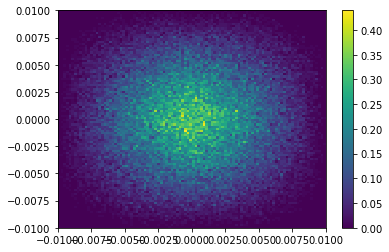

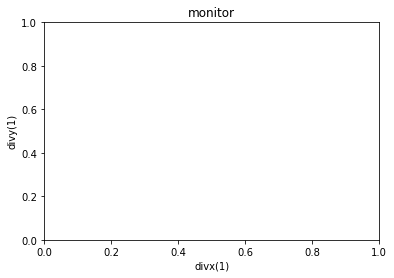

In [6]:
monhist = hh.load('./out-mcvine/step0/monitor.h5')
plt.figure()
H.plot(monhist)

# Parallel simulation

## create script

In [7]:
%%file myinstrument.py
import mcvine, mcvine.components
import os, numpy as np, histogram.hdf as hh
from mcni.components import NDMonitor
from mcni.components.HistogramBasedMonitorMixin import HistogramBasedMonitorMixin
class MyNDMonitor(NDMonitor.NDMonitor, HistogramBasedMonitorMixin):

    def process(self, neutrons):
        super(MyNDMonitor, self).process(neutrons)
        self.save()
        return
    
    def save(self):
        outdir = self.simulation_context.getOutputDirInProgress()
        hh.dump(self.histogram, os.path.join(outdir, "%s.h5" % self.name))
        self.histogram.I[:] = 0
        self.histogram.E2[:] = 0
        return
    
    def _getHistogramFilename(self): return "%s.h5" % self.name
instrument = mcvine.instrument()
instrument.append(mcvine.components.sources.Source_simple('source'), position=(0,0,0))
divxaxis = NDMonitor.Axis(name='divx', expression='vx/vz', bins=100, range=(-0.01, 0.01), unit='1')
divyaxis = NDMonitor.Axis(name='divy', expression='vy/vz', bins=100, range=(-0.01, 0.01), unit='1')
instrument.append(MyNDMonitor('monitor', [divxaxis, divyaxis], size=(0.2, 0.2)), position=(0,0,1))

Overwriting myinstrument.py


## check/debug script

In [8]:
from mcvine import run_script

In [9]:
run_script.run1('./myinstrument.py', 'debug', ncount=10, overwrite_datafiles=True)

In [10]:
ls ./debug

monitor.h5  post-processing-scripts/  step0/


plot z in (0.0, 0.000785388870377)


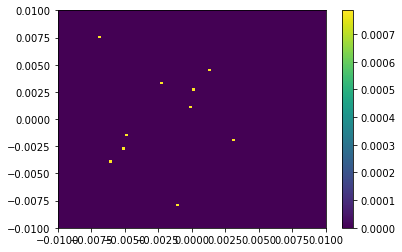

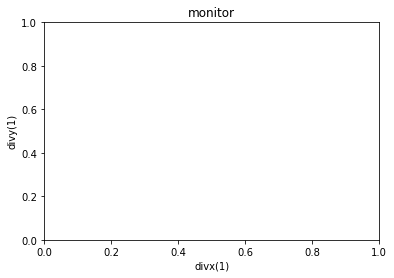

In [11]:
monhist = hh.load('./debug/monitor.h5')
plt.figure()
H.plot(monhist)

## production run

In [12]:
%%time
run_script.run_mpi('./myinstrument.py', 'work', ncount=1e6, nodes=10, overwrite_datafiles=True)

CPU times: user 5.46 ms, sys: 14.8 ms, total: 20.2 ms
Wall time: 5.26 s


In [13]:
ls work/

monitor.h5                rank2-step1/  rank4-step4/  rank7-step2/
post-processing-scripts/  rank2-step2/  rank5-step0/  rank7-step3/
rank0-step0/              rank2-step3/  rank5-step1/  rank7-step4/
rank0-step1/              rank2-step4/  rank5-step2/  rank8-step0/
rank0-step2/              rank3-step0/  rank5-step3/  rank8-step1/
rank0-step3/              rank3-step1/  rank5-step4/  rank8-step2/
rank0-step4/              rank3-step2/  rank6-step0/  rank8-step3/
rank1-step0/              rank3-step3/  rank6-step1/  rank8-step4/
rank1-step1/              rank3-step4/  rank6-step2/  rank9-step0/
rank1-step2/              rank4-step0/  rank6-step3/  rank9-step1/
rank1-step3/              rank4-step1/  rank6-step4/  rank9-step2/
rank1-step4/              rank4-step2/  rank7-step0/  rank9-step3/
rank2-step0/              rank4-step3/  rank7-step1/  rank9-step4/


In [14]:
cat work/rank0-step0/number_of_mc_samples

20000

plot z in (0.0, 3.36144152264e-06)


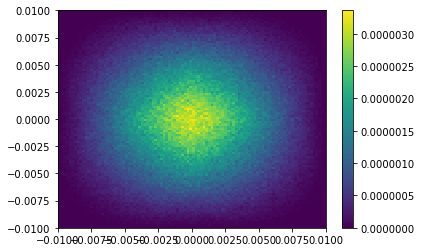

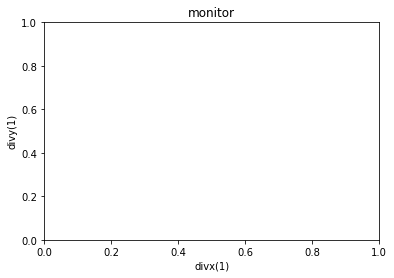

In [15]:
monhist = hh.load('./work//monitor.h5')
plt.figure()
H.plot(monhist)